## Redes y Machine Learning

### 1. Representaciones de rasgos como redes

In [1]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from cdlib import evaluation
from cdlib import algorithms, viz
from pygsp import graphs, filters
from scipy import sparse
from sklearn.metrics.cluster import normalized_mutual_info_score

In [2]:
sails = pd.read_pickle('rasgos_sails.p')

In [3]:
sails.keys()

dict_keys(['agua1253', 'yane1238', 'apur1254', 'apal1257', 'arhu1242', 'mapu1245', 'karo1305', 'araw1276', 'awet1244', 'cent2142', 'bora1263', 'boro1282', 'baur1253', 'chip1262', 'mose1249', 'cavi1250', 'chay1248', 'chol1284', 'coca1259', 'colo1256', 'cube1242', 'desa1247', 'emer1243', 'nort2972', 'guat1253', 'hixk1239', 'inga1252', 'iton1250', 'jama1261', 'hupd1244', 'juru1256', 'kama1373', 'kari1311', 'daww1239', 'awac1239', 'kano1245', 'leco1242', 'lako1248', 'sate1243', 'mats1244', 'moco1246', 'maku1278', 'wich1262', 'mund1330', 'movi1243', 'moch1259', 'pare1272', 'wari1268', 'paez1247', 'pila1245', 'puin1248', 'hual1241', 'sout2991', 'sout2990', 'sant1432', 'tena1240', 'yauy1235', 'ayac1239', 'cusc1236', 'caja1238', 'imba1240', 'nort2980', 'paca1245', 'sanm1289', 'huay1240', 'sala1272', 'jauj1238', 'cane1242', 'rikb1245', 'saba1268', 'nina1238', 'ship1254', 'saki1248', 'tari1256', 'tehu1242', 'tapi1253', 'trum1247', 'trio1238', 'ikpe1245', 'urar1246', 'uruu1244', 'wara1303', 'wayo

In [4]:
sails['mapu1245']

{'ARGEX5-1': 'ARGEX5-1-C',
 'ARGEX5-2': 'ARGEX5-2-C',
 'ARGEX5-3': 'ARGEX5-3-C',
 'ARGEX5-4': 'ARGEX5-4-C',
 'ARGEX5-5': 'ARGEX5-5-D',
 'ARGEX5-6': 'ARGEX5-6-C',
 'ARGEX5-7': 'ARGEX5-7-C',
 'ARGEX5-8': 'ARGEX5-8-C',
 'ARGEX5-9': 'ARGEX5-9-B'}

In [5]:
## valores de rasgos

valores = []

for lengua in sails.keys():
    valores+=list(sails[lengua].values())

In [6]:
valores = list(set(valores))

In [7]:
dict_valores = dict(zip(valores,range(len(valores))))

In [8]:
sails_num = {}

for lengua in sails.keys():
    D = sails[lengua]
    D = {key:dict_valores[D[key]] for key in D.keys()}
    sails_num[lengua]=list(D.values())

In [9]:
sails_num['mapu1245']

[15, 24, 17, 13, 23, 2, 19, 3, 14]

In [49]:
X=[]
for lengua in sails_num.keys():
    X+=[list(sails_num[lengua])]

In [50]:
X = TSNE(n_components=2,perplexity=15,init='pca',random_state=0).fit_transform(X)

In [51]:
#pca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=1)
#X = pca.fit_transform(X)

In [52]:
x=list(zip(*list(X)))[0]
y=list(zip(*list(X)))[1]

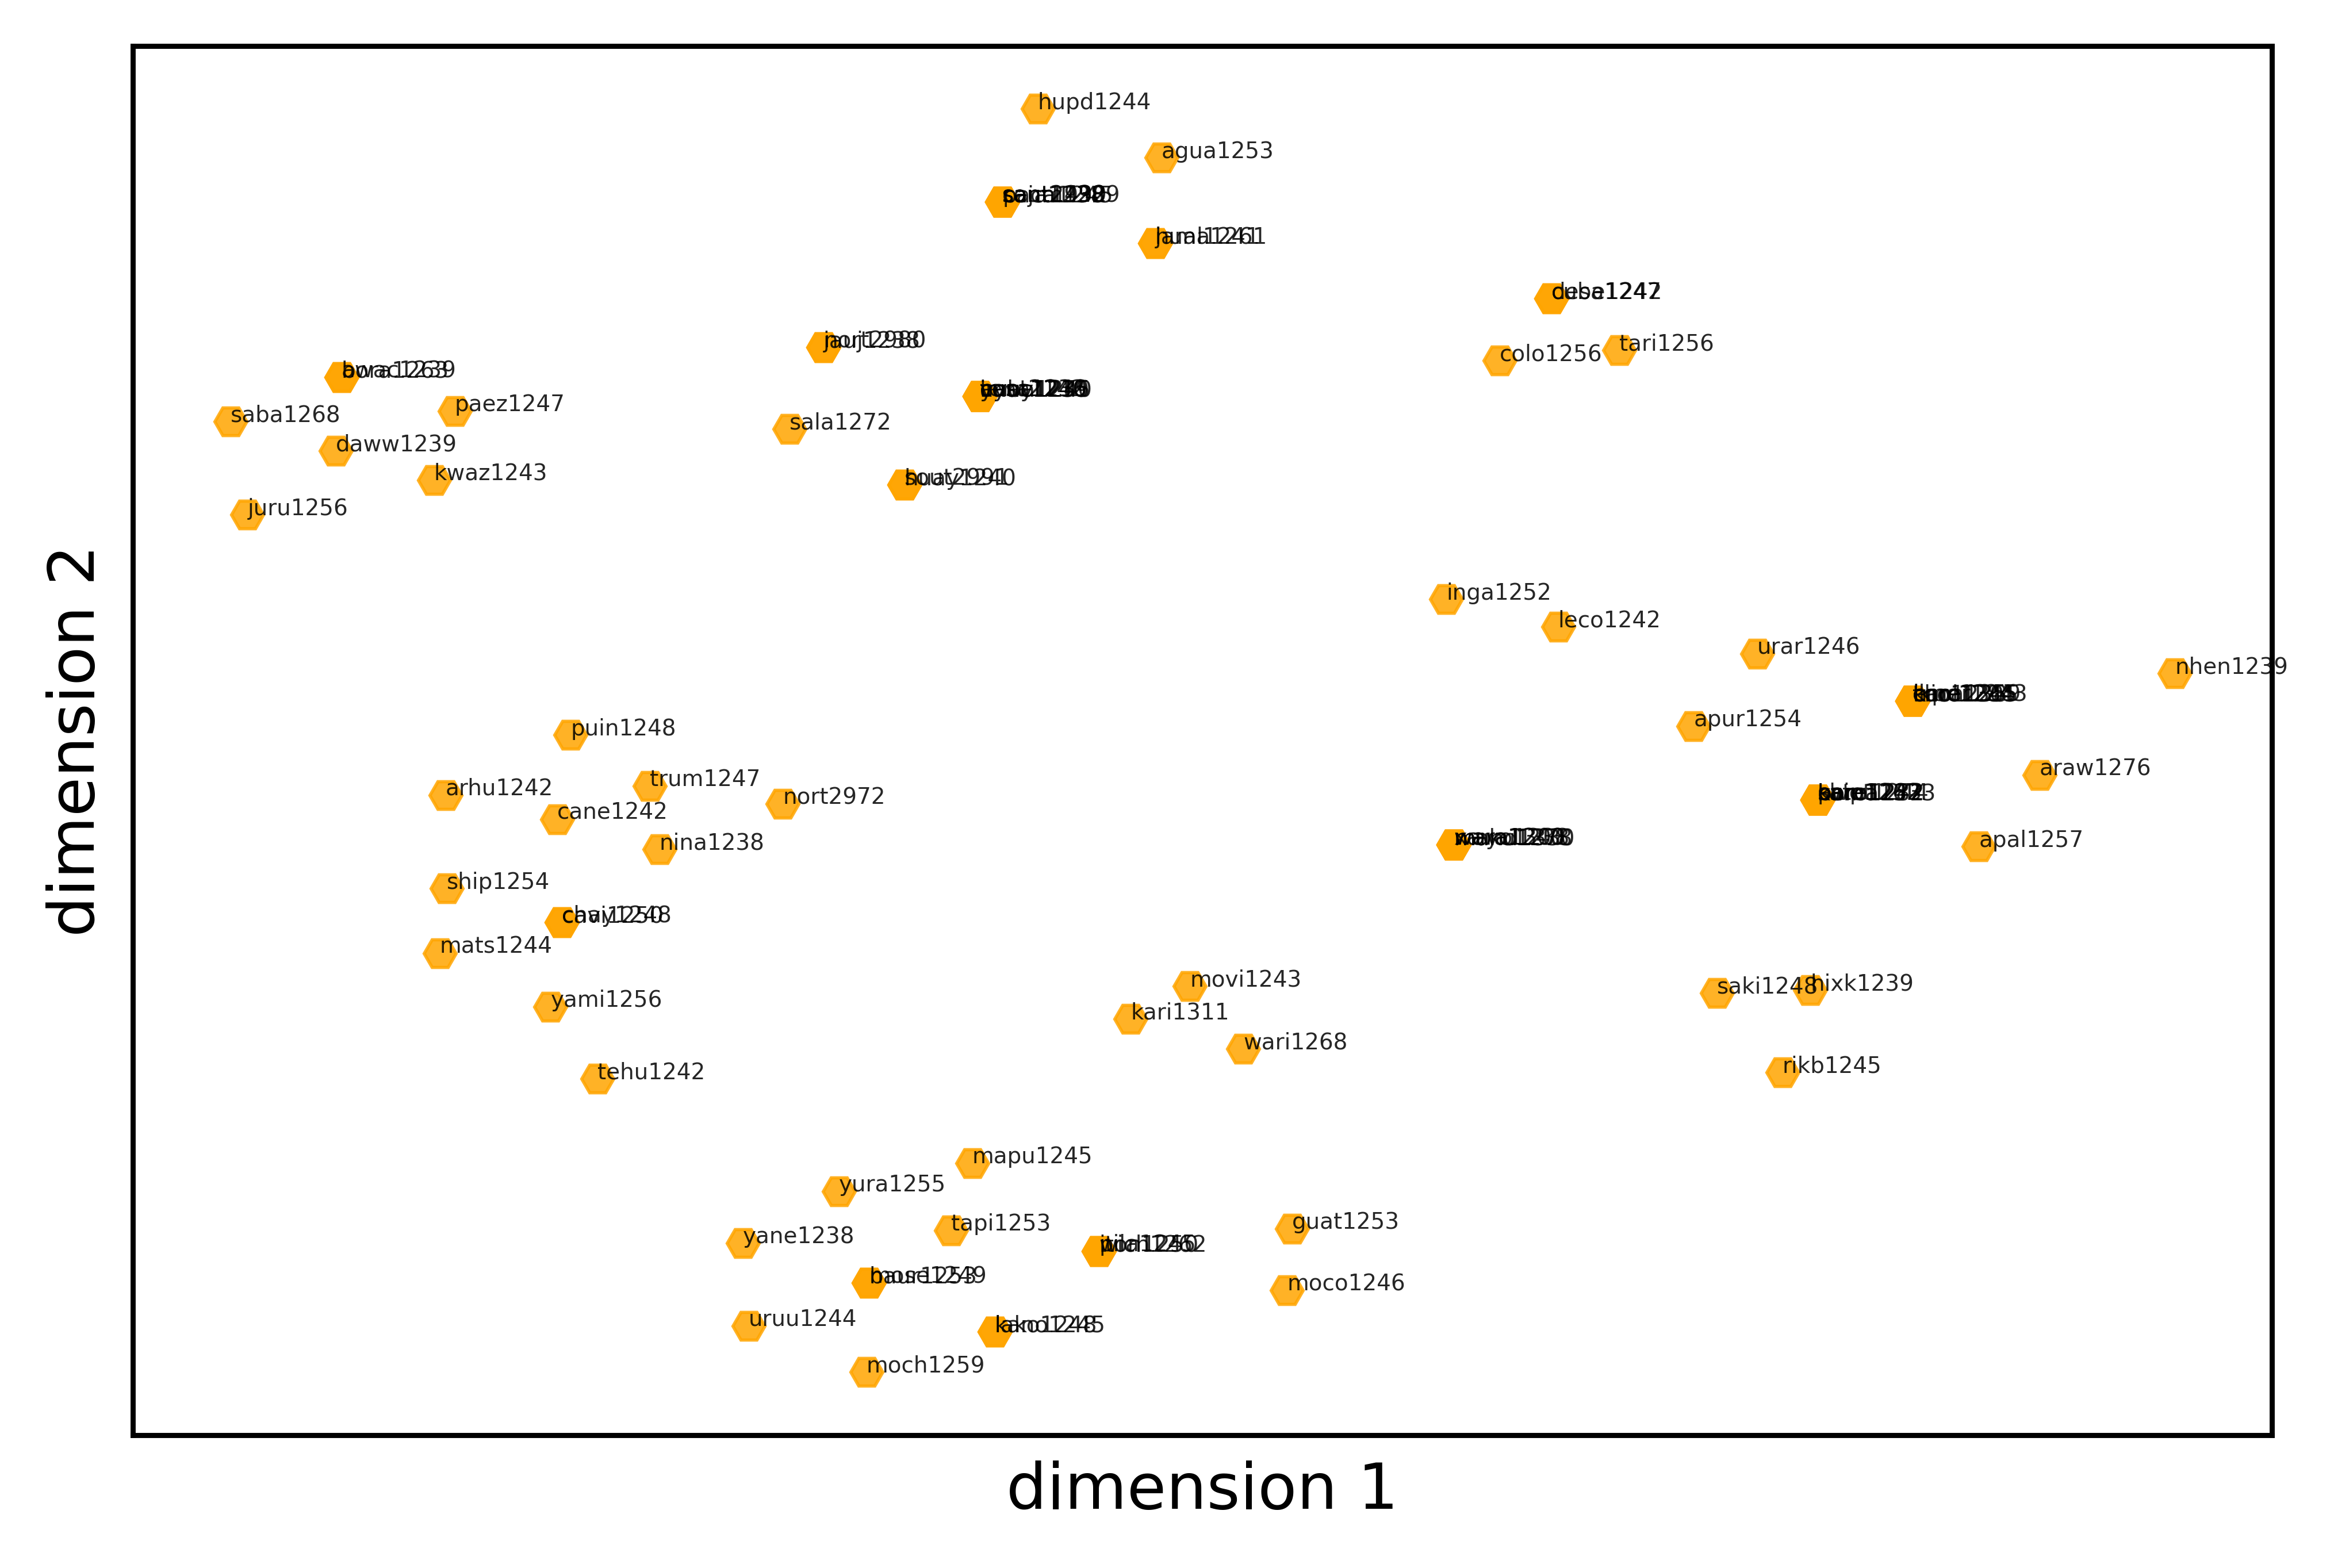

In [53]:
fig, ax = plt.subplots(dpi=800)

for lengua in sails_num.keys():
    i = list(sails_num.keys()).index(lengua)
    ax.annotate(lengua, color='k', xy=(x[i]-0.0004,y[i]-0.0004), fontsize=3.5, alpha=0.85)
#        ax.annotate(labels[i], weight='demi', color='k', xy=(x[i]-0.05,y[i]-0.05), fontsize=4, alpha=0.85)

ax.plot([x[i] for i in [list(sails_num.keys()).index(word) for word in sails_num.keys()]],[y[i] for i in [list(sails_num.keys()).index(word) for word in sails_num.keys()]],'H',color='orange',markersize=5,markeredgewidth=0.5,markeredgecolor=None,alpha=0.85,fillstyle='full',clip_on=True)

plt.grid(False)
#plt.title(str(len(languages))+' languages with '+str(len(keys_comunes))+' features',fontsize=10)
ax.set_yticks([])
ax.set_xticks([])
#plt.legend(loc='best',fontsize=7)
plt.ylabel(r'dimension 2',fontsize=10)
plt.xlabel(r'dimension 1',fontsize=10)
plt.rcParams.update({'font.size': 10})
#plt.savefig('TSNE_sails.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [15]:
## ¿Cómo construimos una red a partir de estos datos?

In [54]:
## noción de distancia

def hamming(glotto1,glotto2):
    d = 0
    n = 0
    language1 = sails[glotto1]
    language2 = sails[glotto2]
    for feat in language1.keys():
        if feat in language2.keys():
            if language1[feat] != language2[feat]:
                d += 1.0
            n += 1.0
    return d/n

In [56]:
hamming('mapu1245','mapu1245')

0.0

In [57]:
## vecinos cercanos!!!

In [19]:
## grafos!!!
import networkx as nx

def GRAPH_knn(k):
    
    ## distancias
    D = {lengua:{} for lengua in sails.keys()}
    for lengua in sails.keys():
        for lengualengua in sails.keys():
            H = hamming(lengua,lengualengua)
            D[lengua][lengualengua]=1-H
            
    ## grafo
    G=nx.Graph()
    for key in D.keys():

        D_ordered = list({k: v for k, v in sorted(D[key].items(), key=lambda item: item[1],reverse=True)}.items())[1:k+1]
        D_ordered = [item[0] for item in D_ordered]
        for keykey in D_ordered:
            if G.has_edge(key,keykey)==False:
                if key!=keykey:
                    G.add_edge(key,keykey,weight=D[key][keykey])
        
    return G

In [20]:
graphs_k = {}

for k in range(2,16):
    graphs_k[k] = GRAPH_knn(k)

In [21]:
for k in graphs_k.keys():
    print(k,len(graphs_k[k]),len(graphs_k[k].edges))

2 88 141
3 88 207
4 88 266
5 88 328
6 88 383
7 88 431
8 88 489
9 88 543
10 88 592
11 88 650
12 88 702
13 88 758
14 88 814
15 88 872


### 2. Exploremos k

In [22]:
!pip install cdlib

In [89]:
communities = {}

for k in graphs_k.keys():
    G=graphs_k[k]
    communities[k]=algorithms.louvain(G)

In [90]:
modularity = {}

for k in graphs_k.keys():
    modularity[k]=evaluation.newman_girvan_modularity(graphs_k[k],communities[k]).score

In [91]:
modularity

{2: 0.8102955907211696,
 3: 0.7811233771837255,
 4: 0.7752815090880097,
 5: 0.7514501657561292,
 6: 0.7378240404422366,
 7: 0.7260082239034289,
 8: 0.7011176143777365,
 9: 0.6883614136497838,
 10: 0.6668054494874835,
 11: 0.6431849826959143,
 12: 0.6288519039239263,
 13: 0.6178589303538498,
 14: 0.5985781493754467,
 15: 0.5910799353242799}

In [92]:
number_com = {}
density = {}
communities = {}

for k in graphs_k.keys():
    
    g = graphs_k[k]
    density[k]=nx.density(g)
    coms = algorithms.louvain(g)
    Q = dict(coms.to_node_community_map())
    Q = {key:Q[key][0] for key in Q.keys()}
    N = len(set(Q.values()))
    number_com[k]=N
    communities[k] = Q

In [93]:
number_com

{2: 9,
 3: 7,
 4: 7,
 5: 6,
 6: 6,
 7: 5,
 8: 5,
 9: 5,
 10: 5,
 11: 5,
 12: 5,
 13: 4,
 14: 4,
 15: 4}

In [94]:
density

{2: 0.03683385579937304,
 3: 0.054075235109717866,
 4: 0.06948798328108673,
 5: 0.08568443051201671,
 6: 0.10005224660397075,
 7: 0.1125914315569488,
 8: 0.12774294670846395,
 9: 0.14184952978056425,
 10: 0.15464994775339602,
 11: 0.1698014629049112,
 12: 0.1833855799373041,
 13: 0.1980146290491118,
 14: 0.21264367816091953,
 15: 0.2277951933124347}

In [95]:
for k in graphs_k.keys():
    g = graphs_k[k]
    print(k,nx.is_connected(g))

2 False
3 False
4 False
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True


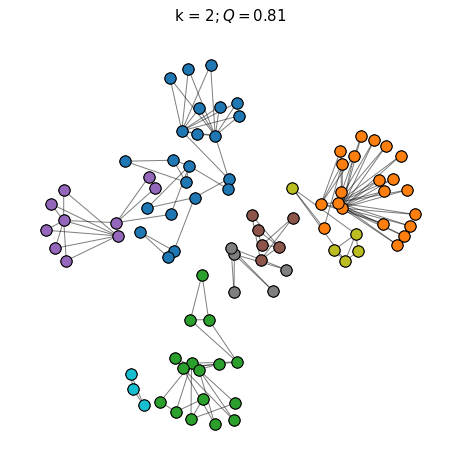

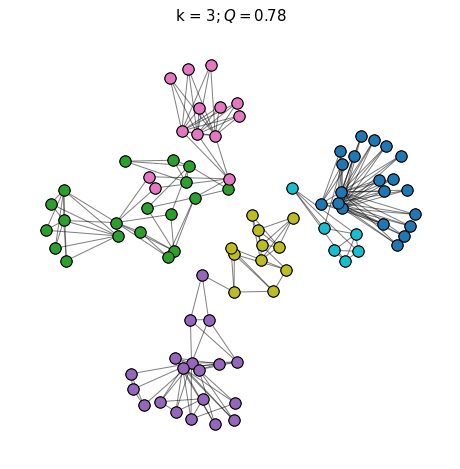

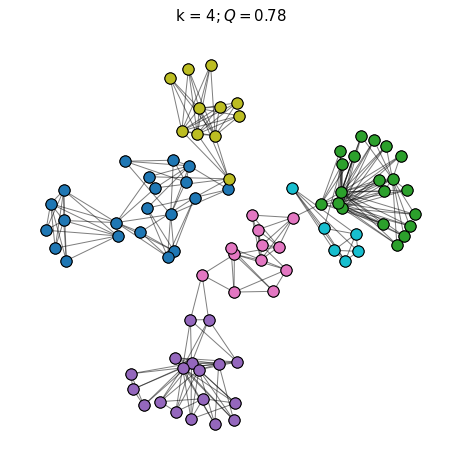

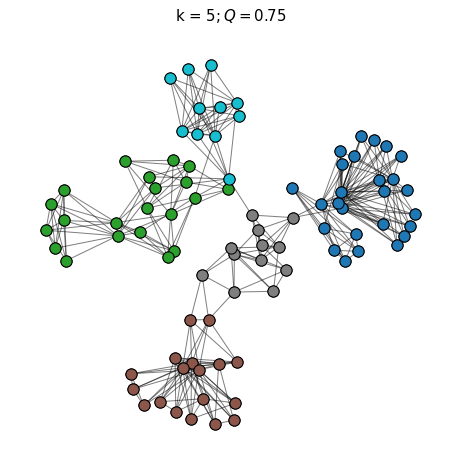

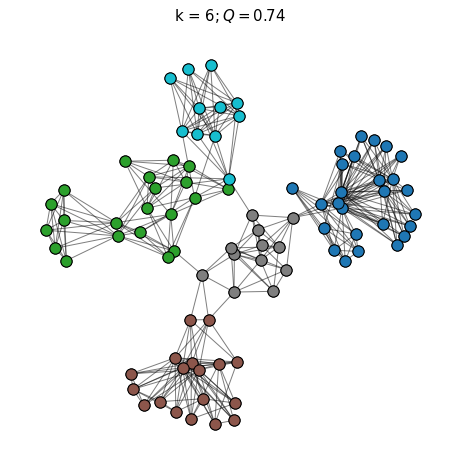

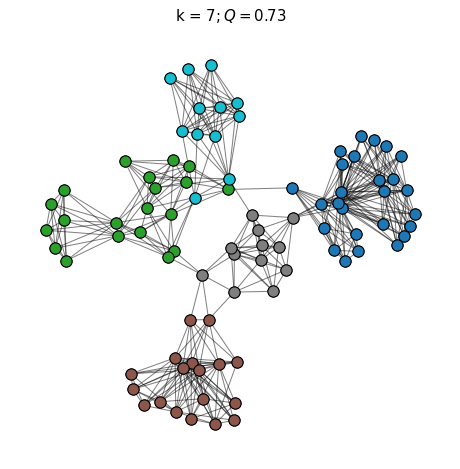

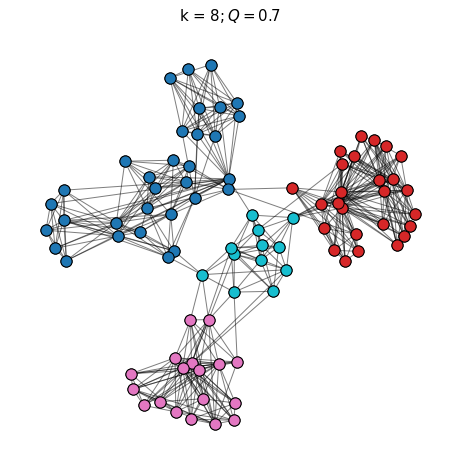

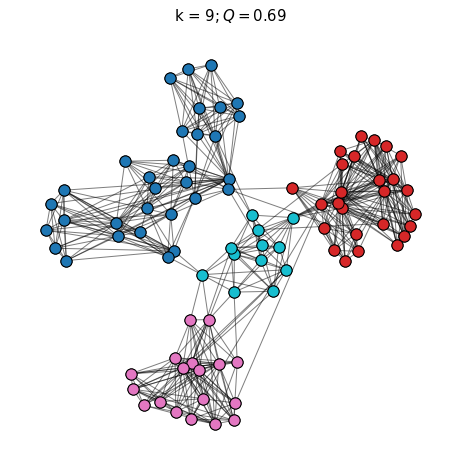

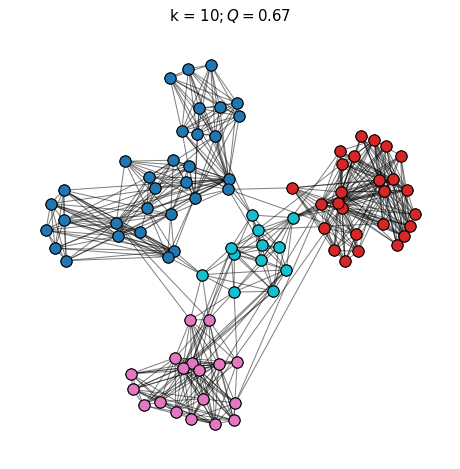

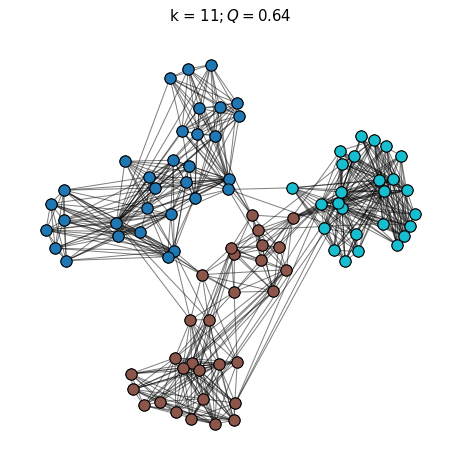

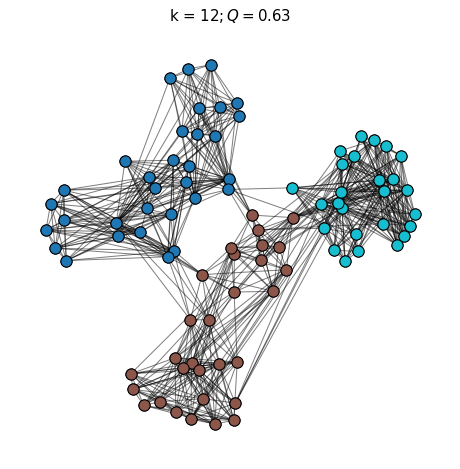

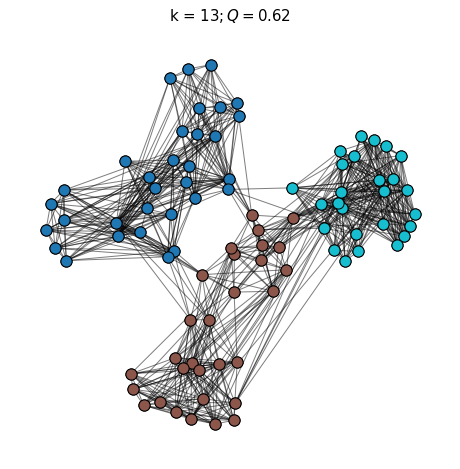

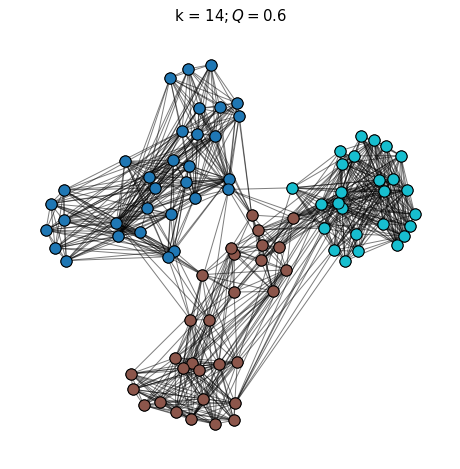

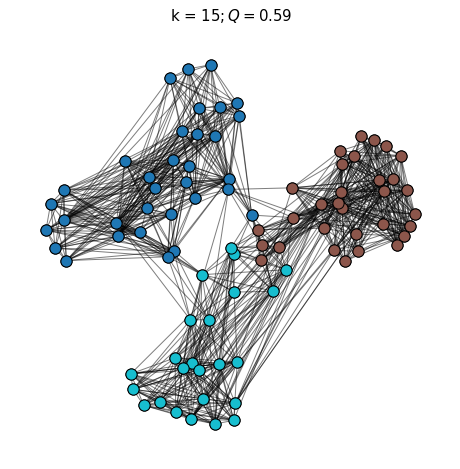

In [117]:
from cdlib import algorithms, viz
g = graphs_k[7]
pos = nx.kamada_kawai_layout(g)

for k in graphs_k.keys():
    g = graphs_k[k]
    coms = algorithms.louvain(g,resolution=2)
    #pos = nx.kamada_kawai_layout(g)
    viz.plot_network_clusters(g, coms, pos, node_size=125,cmap=plt.get_cmap('tab10'))
    plt.title('k = '+str(k)+'$ ;Q = $'+str(round(modularity[k],2)),fontsize=15)

### 3. Clustering

In [97]:
## trabajemos con k = 7

G = graphs_k[7]

## matriz laplaciana
L = nx.laplacian_matrix(G)

In [98]:
L

<88x88 sparse matrix of type '<class 'numpy.float64'>'
	with 950 stored elements in Compressed Sparse Row format>

In [99]:
eig_val, U = sparse.linalg.eigsh(L, k=20, which='SM')

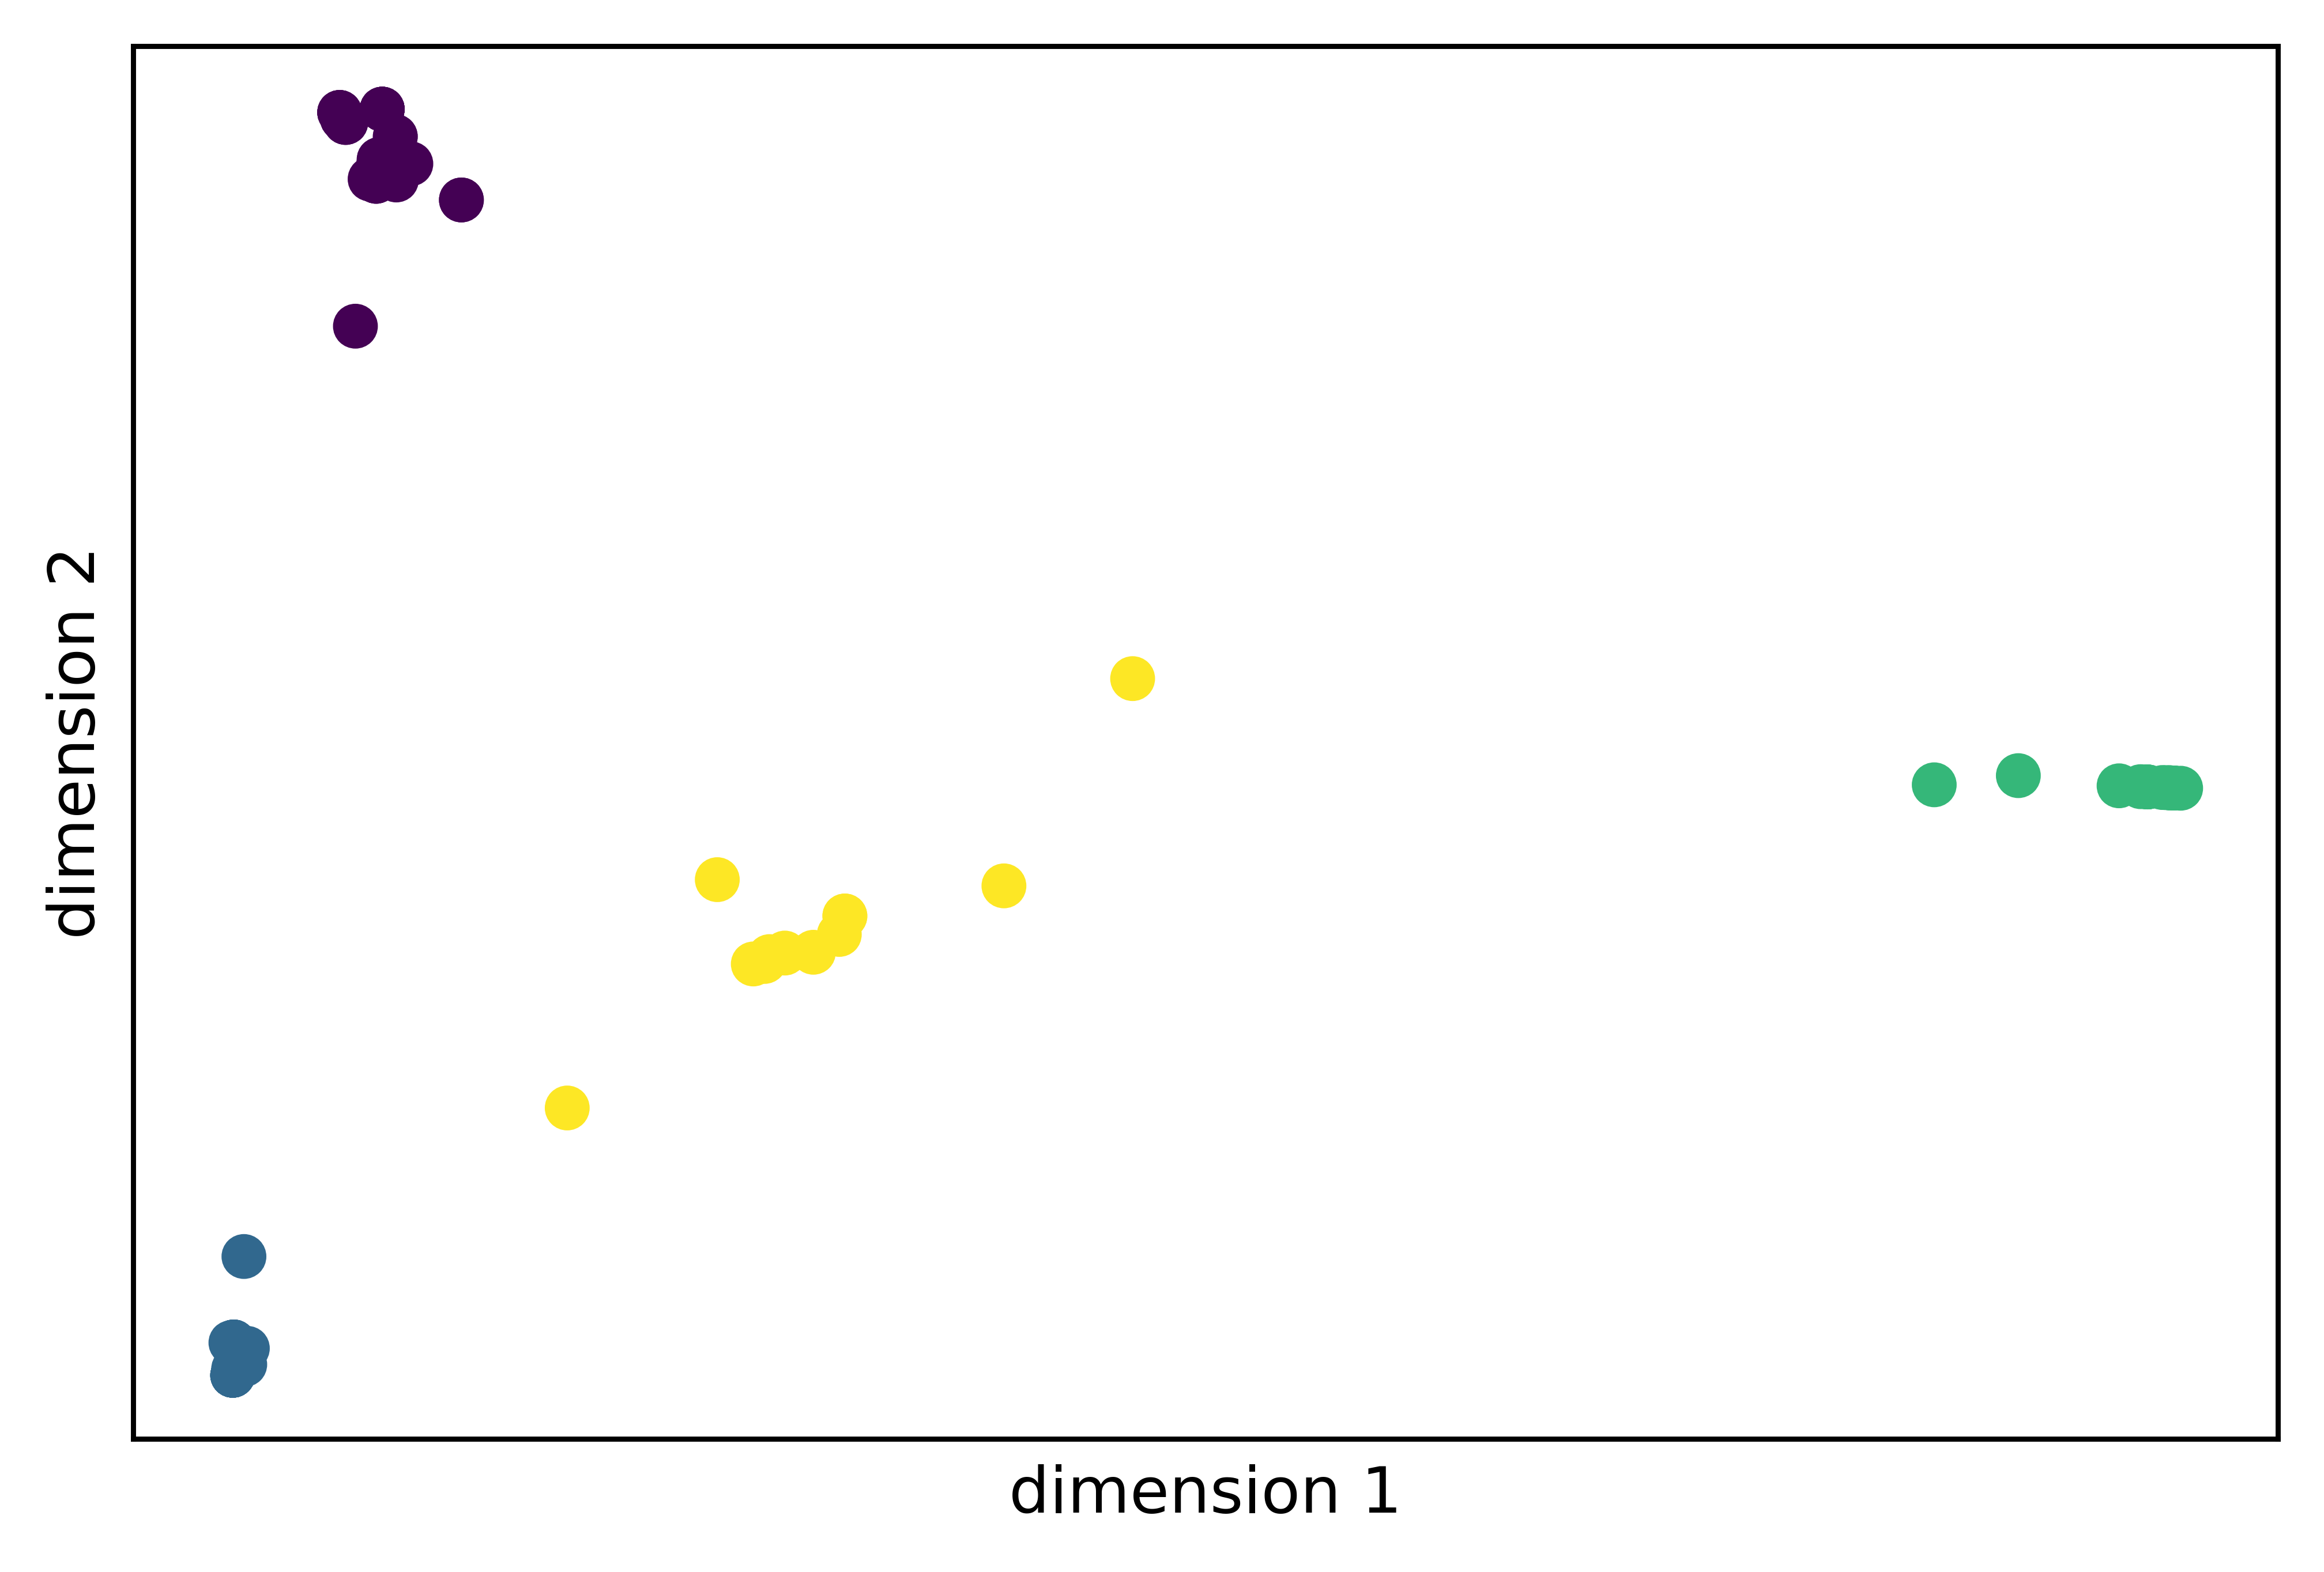

In [100]:
## visualicemos el grafo en dos dimensiones

fig, ax = plt.subplots(dpi=800)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
y_pred = kmeans.fit_predict(U[:,1:3])

ax.scatter(U[:,1:3][:, 0], U[:,1:3][:, 1],c=y_pred)

plt.grid(False)
#plt.title(str(len(languages))+' languages with '+str(len(keys_comunes))+' features',fontsize=10)
ax.set_yticks([])
ax.set_xticks([])
#plt.legend(loc='best',fontsize=7)
plt.ylabel(r'dimension 2',fontsize=10)
plt.xlabel(r'dimension 1',fontsize=10)
plt.rcParams.update({'font.size': 10})
#plt.savefig('TSNE_sails.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [101]:
dict_kmeans = {}

for k in graphs_k.keys():
    G = graphs_k[k]
    L = nx.laplacian_matrix(G)
    eig_val, U = sparse.linalg.eigsh(L, k=20, which='SM')
    kmeans = KMeans(n_clusters=4)
    y_pred = kmeans.fit_predict(U[:,1:5])
    dict_kmeans[k]=dict(zip(G.nodes,y_pred))

In [102]:
dict_kmeans[7]

{'agua1253': 1,
 'jama1261': 1,
 'hual1241': 1,
 'sout2990': 1,
 'sant1432': 1,
 'caja1238': 1,
 'paca1245': 1,
 'sanm1289': 1,
 'yane1238': 2,
 'mapu1245': 2,
 'baur1253': 2,
 'mose1249': 2,
 'kano1245': 2,
 'lako1248': 2,
 'yura1255': 2,
 'guat1253': 2,
 'apur1254': 0,
 'apal1257': 0,
 'karo1305': 0,
 'araw1276': 0,
 'awet1244': 0,
 'boro1282': 0,
 'chip1262': 0,
 'chol1284': 0,
 'arhu1242': 3,
 'nina1238': 3,
 'cane1242': 3,
 'trum1247': 3,
 'cent2142': 1,
 'sout2991': 1,
 'tena1240': 1,
 'yauy1235': 1,
 'ayac1239': 1,
 'cusc1236': 1,
 'imba1240': 1,
 'nort2980': 1,
 'bora1263': 1,
 'daww1239': 1,
 'awac1239': 1,
 'kwaz1243': 1,
 'hupd1244': 1,
 'juru1256': 1,
 'paez1247': 1,
 'saba1268': 1,
 'cavi1250': 3,
 'chay1248': 3,
 'ship1254': 3,
 'mats1244': 3,
 'yami1256': 3,
 'coca1259': 0,
 'colo1256': 1,
 'cube1242': 1,
 'desa1247': 1,
 'tari1256': 1,
 'emer1243': 0,
 'nort2972': 3,
 'moco1246': 2,
 'iton1250': 2,
 'hixk1239': 0,
 'inga1252': 1,
 'maku1278': 0,
 'wich1262': 2,
 'pila12

In [103]:
coms = {}
for k in communities.keys():
    coms[k]={key:communities[k][key] for key in dict_kmeans[k].keys()}

In [104]:
communities.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [105]:
for k in coms.keys():
    print(k,normalized_mutual_info_score(list(dict_kmeans[k].values()), list(coms[k].values())))

2 0.7402866770117315
3 0.754177325136162
4 0.7748600683602898
5 0.8706265285441671
6 0.8706265285441671
7 0.9167393472232576
8 0.9167393472232576
9 0.9167393472232576
10 0.9151382711596809
11 0.9151382711596809
12 0.9151382711596809
13 1.0
14 1.0
15 1.0


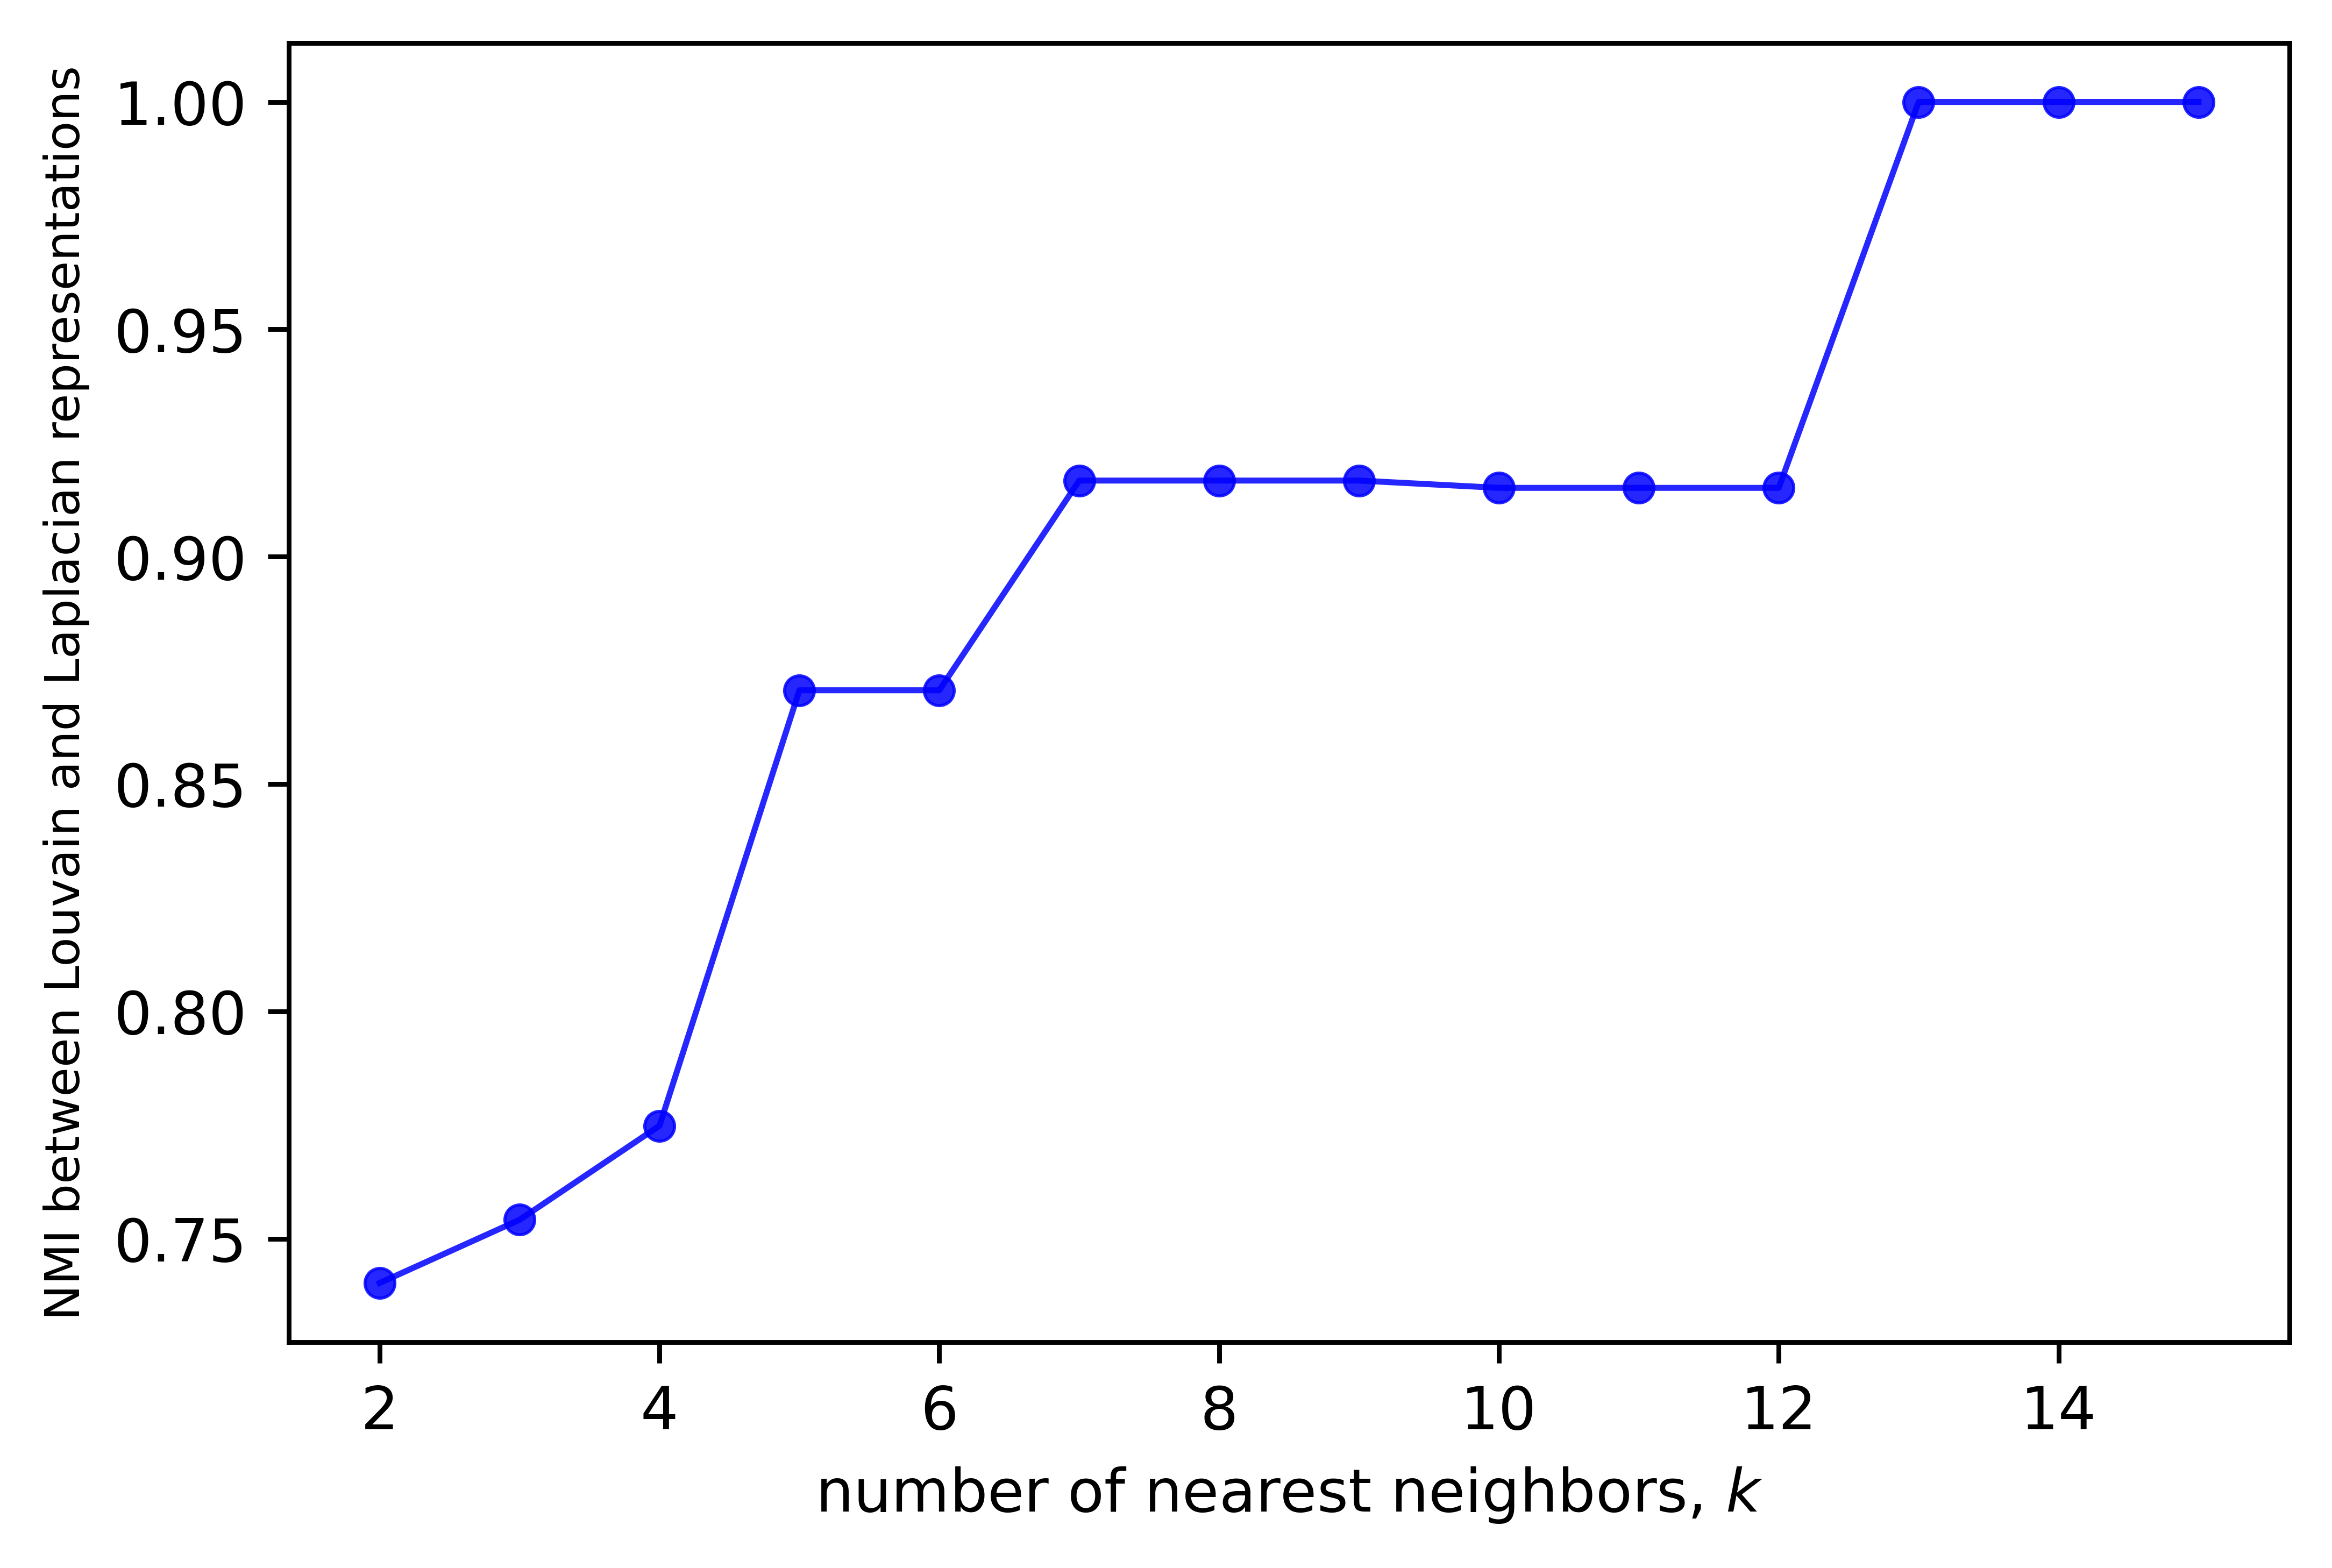

In [106]:
fig, ax = plt.subplots(dpi=800)

ax.plot(coms.keys(),[normalized_mutual_info_score(list(dict_kmeans[k].values()), list(coms[k].values())) for k in coms.keys()],marker='o',color='blue',linewidth=1,markersize=5,markeredgewidth=0.5,markeredgecolor=None,alpha=0.85,fillstyle='full',clip_on=True)

plt.grid(False)
#plt.legend(loc='best',fontsize=7)
plt.ylabel(r'NMI between Louvain and Laplacian representations',fontsize=8)
plt.xlabel(r'number of nearest neighbors, $k$',fontsize=10)
plt.rcParams.update({'font.size': 10})
plt.show()

### 4. node2vec

In [40]:
!pip install node2vec

In [107]:
from node2vec import Node2Vec

In [108]:
models = {}

for k in graphs_k.keys():
    G = graphs_k[k]
    n2v_obj = Node2Vec(G, dimensions=100, walk_length=10, num_walks=25, p=1, q=1, workers=1)
    models[k] = n2v_obj.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 199.37it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 179.29it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 185.78it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 167.51it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 188.40it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 139.81it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 171.87it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 167.11it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 174.04it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 168.26it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 116.05it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 165.97it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 165.45it/s]


Computing transition probabilities:   0%|          | 0/88 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 25/25 [00:00<00:00, 159.66it/s]


In [123]:
X=[]
for lengua in graphs_k[7].nodes:
    X+=[list(models[7].wv.get_vector(lengua))]

In [124]:
X = TSNE(n_components=2,perplexity=25,init='pca',random_state=0).fit_transform(X)

In [125]:
#pca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=1)
#X = pca.fit_transform(X)

In [126]:
x=list(zip(*list(X)))[0]
y=list(zip(*list(X)))[1]

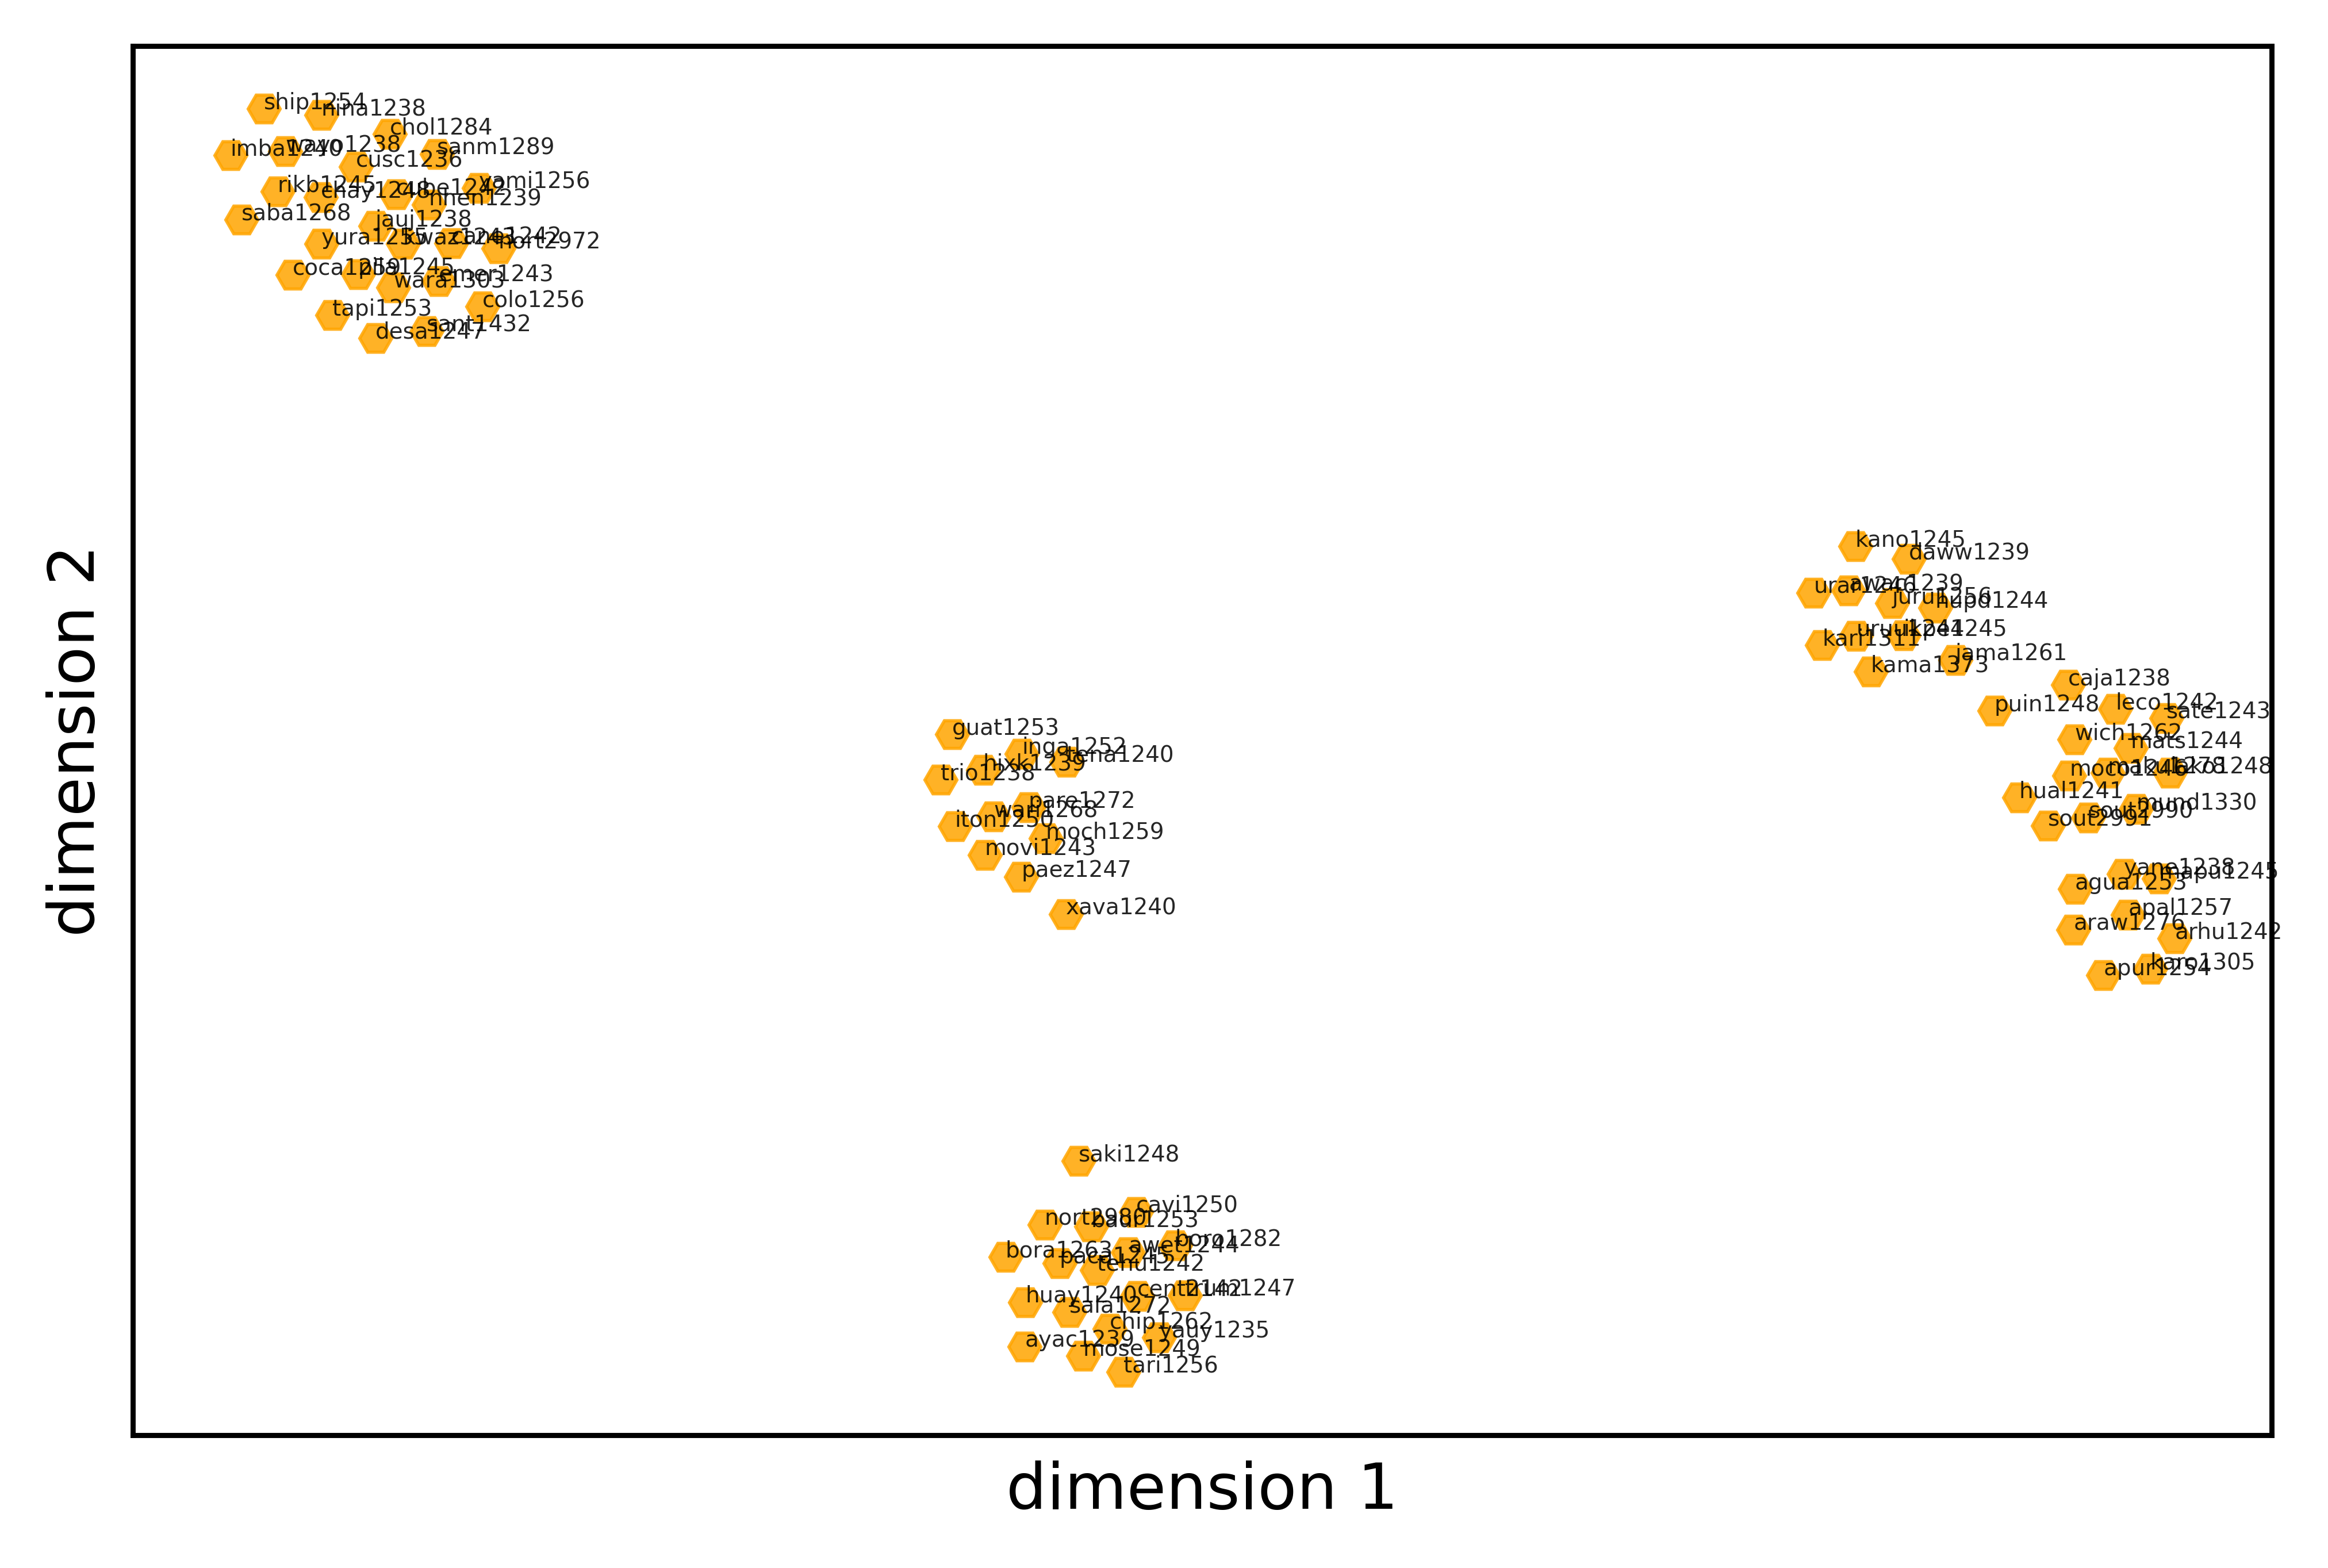

In [127]:
fig, ax = plt.subplots(dpi=800)

for lengua in sails_num.keys():
    i = list(sails_num.keys()).index(lengua)
    ax.annotate(lengua, color='k', xy=(x[i]-0.0004,y[i]-0.0004), fontsize=3.5, alpha=0.85)
#        ax.annotate(labels[i], weight='demi', color='k', xy=(x[i]-0.05,y[i]-0.05), fontsize=4, alpha=0.85)

ax.plot([x[i] for i in [list(sails_num.keys()).index(word) for word in sails_num.keys()]],[y[i] for i in [list(sails_num.keys()).index(word) for word in sails_num.keys()]],'H',color='orange',markersize=5,markeredgewidth=0.5,markeredgecolor=None,alpha=0.85,fillstyle='full',clip_on=True)

plt.grid(False)
#plt.title(str(len(languages))+' languages with '+str(len(keys_comunes))+' features',fontsize=10)
ax.set_yticks([])
ax.set_xticks([])
#plt.legend(loc='best',fontsize=7)
plt.ylabel(r'dimension 2',fontsize=10)
plt.xlabel(r'dimension 1',fontsize=10)
plt.rcParams.update({'font.size': 10})
#plt.savefig('TSNE_sails.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [113]:
pred_n2v = {}

for k in graphs_k.keys():

    X=[]
    for lengua in graphs_k[7].nodes:
        X+=[list(models[k].wv.get_vector(lengua))]
    kmeans = KMeans(n_clusters=4)
    y_pred = kmeans.fit_predict(X)
    dict_n2v = dict(zip(graphs_k[7].nodes,y_pred))
    dict_n2v = {key:dict_n2v[key] for key in dict_kmeans[7].keys()}
    pred_n2v[k] = dict_n2v

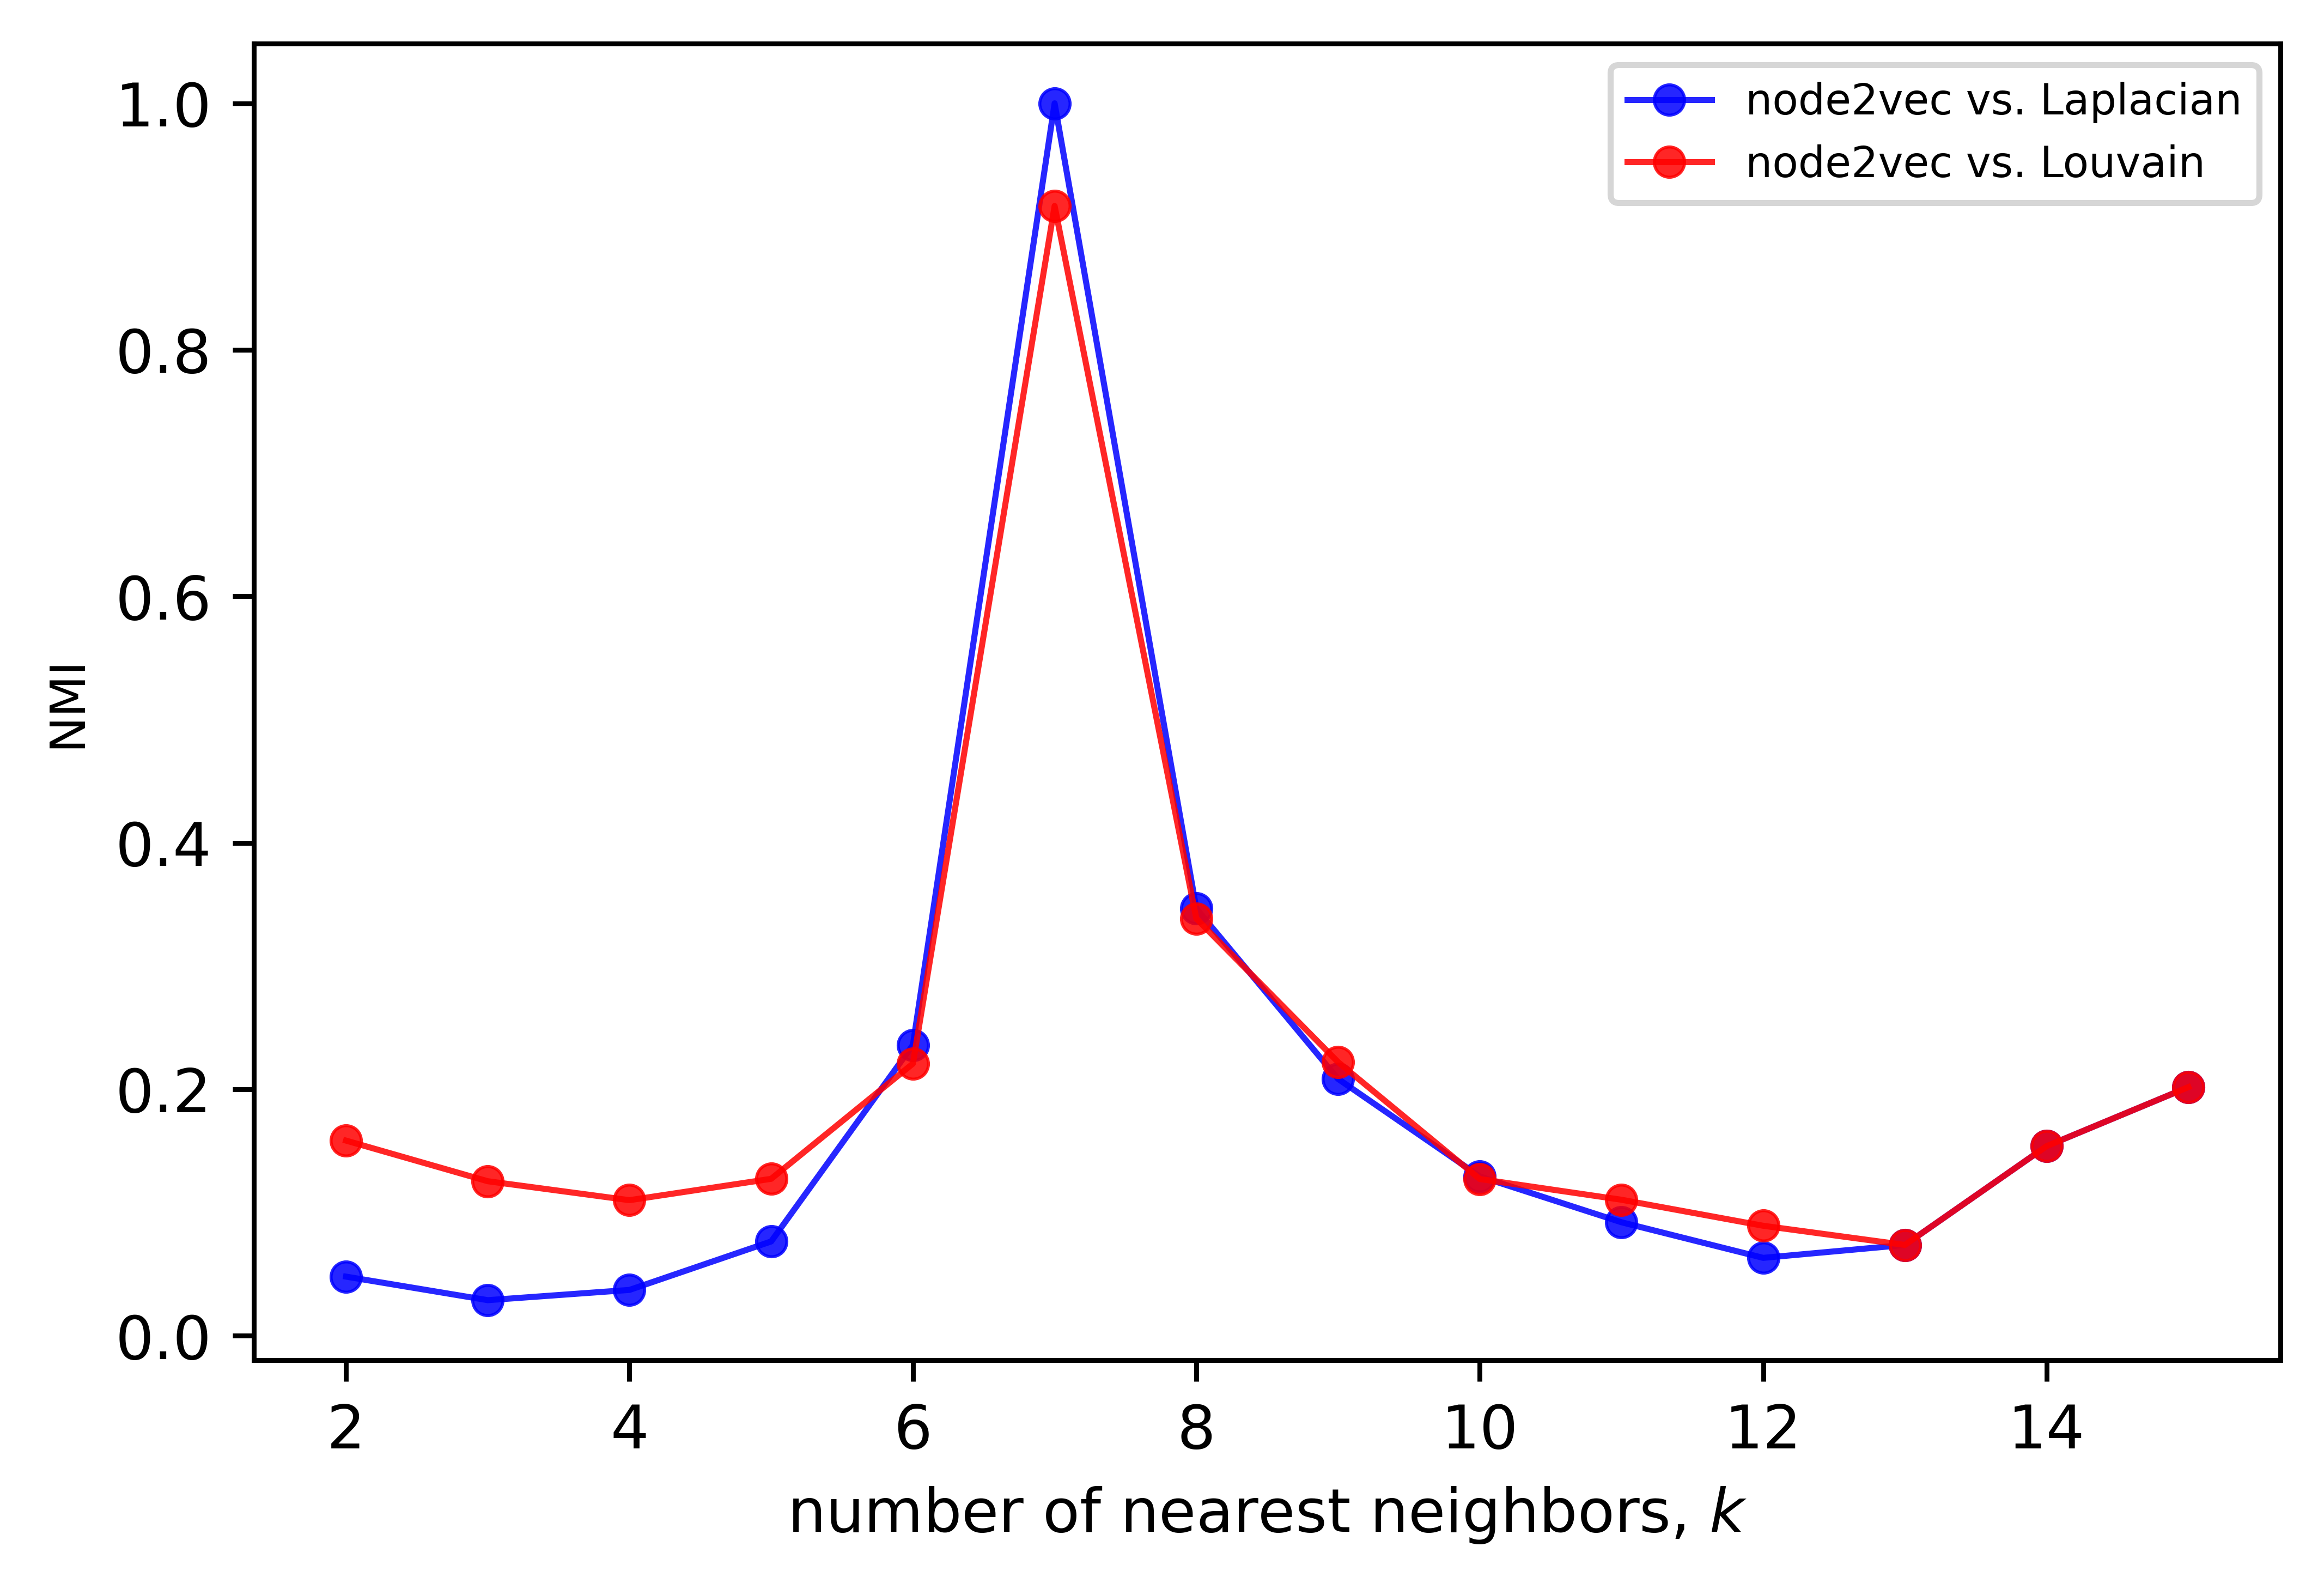

In [114]:
fig, ax = plt.subplots(dpi=800)

ax.plot(pred_n2v.keys(),[normalized_mutual_info_score(list(dict_kmeans[k].values()), list(pred_n2v[k].values())) for k in coms.keys()],marker='o',color='blue',linewidth=1,markersize=5,markeredgewidth=0.5,markeredgecolor=None,alpha=0.85,fillstyle='full',clip_on=True,label='node2vec vs. Laplacian')
ax.plot(pred_n2v.keys(),[normalized_mutual_info_score(list(coms[k].values()), list(pred_n2v[k].values())) for k in coms.keys()],marker='o',color='r',linewidth=1,markersize=5,markeredgewidth=0.5,markeredgecolor=None,alpha=0.85,fillstyle='full',clip_on=True,label='node2vec vs. Louvain')

plt.grid(False)
plt.legend(loc='best',fontsize=7)
plt.ylabel(r'NMI',fontsize=8)
plt.xlabel(r'number of nearest neighbors, $k$',fontsize=10)
plt.rcParams.update({'font.size': 10})
plt.show()

In [79]:
len(pred_n2v.keys())

14

In [81]:
[normalized_mutual_info_score(list(dict_kmeans[k].values()), list(pred_n2v[k].values())) for k in coms.keys()]

[]

In [84]:
coms.keys()

dict_keys([])